In [1]:
# Script A: ML Pipeline for Uncleaned (Raw) ÖKOBAUDAT EPD Data
%pip install pandas numpy tensorflow scikit-learn xgboost openpyxl

# 1. Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Note: you may need to restart the kernel to use updated packages.


In [2]:

# 2. Load the uncleaned dataset
# 'Okenbaudt1.xlsx' is available in the working directory. This is the raw data with the different inconsistencies.
df = pd.read_excel("EPDs_as_is.xlsx", engine='openpyxl')

# Select relevant features (5 numerical + 7 categorical) and the target variable as identified in the conference paper earlier
features = [
    'Name (en)', 'Category', 'Country code', 'Reference size', 'Reference unit',
    'Reference Flow Name', 'Modul', 'PERT', 'PENRT', 'SM', 'NHWD', 'RWD'
]
target = 'GWPtotal (A2)'
df = df[features + [target]].copy()

# Because this is raw data, it contains missing values or invalid entries that in the cleaned dataset are removed.
# Drop rows with any missing required feature or target.
df.dropna(subset=features + [target], inplace=True)
# (This will remove EPD entries that have no country code, no target value, or other missing fields, mirroring the cleaning done in the processed dataset.)

# **Note:** We are NOT removing outliers or normalizing units in this script.
# The raw data may include extreme values (e.g., very large or negative impact values) and varying declared units.
# Those issues were handled in the cleaned dataset, but here we proceed without extra cleaning to keep the pipeline logic identical.
# The model performance on raw data may be affected by these anomalies.

# 3. Train-test split (80/20)
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Ensure we use the same random_state as in the cleaned script for a comparable split.

# 4. Frequency encoding for high-cardinality features (Product Name, Reference Flow Name)
prod_freq = X_train['Name (en)'].value_counts()
flow_freq = X_train['Reference Flow Name'].value_counts()
X_train['Product_freq'] = X_train['Name (en)'].map(prod_freq)
X_test['Product_freq']  = X_test['Name (en)'].map(prod_freq).fillna(0)
X_train['Flow_freq'] = X_train['Reference Flow Name'].map(flow_freq)
X_test['Flow_freq']  = X_test['Reference Flow Name'].map(flow_freq).fillna(0)
# Unseen products/flows in test get frequency 0 (not present in training).
# This encoding is identical to the cleaned pipeline, but note: the raw training data 
# has slightly more unique products/flows, including some rare ones.

# Drop original text columns after encoding
X_train = X_train.drop(['Name (en)', 'Reference Flow Name'], axis=1)
X_test  = X_test.drop(['Name (en)', 'Reference Flow Name'], axis=1)

# 5. Define numeric and categorical feature lists (same as Script A)
numeric_features = ['Reference size', 'PERT', 'PENRT', 'SM', 'NHWD', 'RWD', 'Product_freq', 'Flow_freq']
categorical_features = ['Category', 'Country code', 'Reference unit', 'Modul']

# 6. Preprocessing pipeline (StandardScaler for numeric, OneHotEncoder for categorical)
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
])
# Note: In raw data, 'Reference size' and impact values like PERT, etc., might vary more widely due to inconsistent units or outliers.
# StandardScaler will normalize their scale, but it doesn't remove outlier influence or reconcile unit differences 
# (those would need domain-specific handling if required).

# 7. Preprocess data for ANN
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed  = preprocessor.transform(X_test)
n_features = X_train_preprocessed.shape[1]

# 8. Metrics function (R^2, RMSE, MAE, MAPE) – same as before for both train and test evaluation

def compute_metrics(y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    mask = y_true != 0
    mape = np.nan if mask.sum() == 0 else np.mean(np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100
    return r2, rmse, mae, mape

# 9. Train and evaluate models (SVR, ANN, Decision Tree, Random Forest, XGBoost)

# 9.1 SVR
print("Training SVR model on raw data...")
svr_model = SVR(kernel='rbf')
svr_pipeline = Pipeline([('preprocess', preprocessor), ('regressor', svr_model)])
svr_cv_scores = cross_val_score(svr_pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"SVR 5-fold CV R^2: {svr_cv_scores.mean():.3f} ± {svr_cv_scores.std():.3f}")
svr_pipeline.fit(X_train, y_train)
svr_preds = svr_pipeline.predict(X_test)
svr_r2, svr_rmse, svr_mae, svr_mape = compute_metrics(y_test, svr_preds)
print(f"SVR Test Metrics – R²: {svr_r2:.3f}, RMSE: {svr_rmse:.3f}, MAE: {svr_mae:.3f}, MAPE: {svr_mape:.2f}%")
pd.DataFrame({'Actual': y_test.values, 'Predicted': svr_preds}).to_csv("predictions_SVR.csv", index=False)
pd.DataFrame([{'R2': svr_r2, 'RMSE': svr_rmse, 'MAE': svr_mae, 'MAPE(%)': svr_mape}]).to_csv("metrics_SVR.csv", index=False)

# 9.2 ANN (TensorFlow MLP)
print("Training ANN model on raw data...")
def create_ann_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

ann_model = create_ann_model(n_features)
# 5-fold cross-validation for ANN (manual)
X_train_array = np.array(X_train_preprocessed)
y_train_array = np.array(y_train)
cv_r2_scores = []
fold_size = X_train_array.shape[0] // 5
for fold in range(5):
    val_start = fold * fold_size
    val_end = val_start + fold_size if fold < 4 else X_train_array.shape[0]
    X_val = X_train_array[val_start:val_end]
    y_val = y_train_array[val_start:val_end]
    X_tr = np.concatenate([X_train_array[:val_start], X_train_array[val_end:]], axis=0)
    y_tr = np.concatenate([y_train_array[:val_start], y_train_array[val_end:]], axis=0)
    model_fold = create_ann_model(n_features)
    model_fold.fit(X_tr, y_tr, epochs=30, batch_size=32, verbose=0)
    y_val_pred = model_fold.predict(X_val).flatten()
    cv_r2_scores.append(r2_score(y_val, y_val_pred))
print(f"ANN 5-fold CV R^2: {np.mean(cv_r2_scores):.3f} ± {np.std(cv_r2_scores):.3f}")
# Train final ANN on all training data
ann_model.fit(X_train_preprocessed, y_train_array, epochs=50, batch_size=32, verbose=0)
ann_preds = ann_model.predict(X_test_preprocessed).flatten()
ann_r2, ann_rmse, ann_mae, ann_mape = compute_metrics(y_test, ann_preds)
print(f"ANN Test Metrics – R²: {ann_r2:.3f}, RMSE: {ann_rmse:.3f}, MAE: {ann_mae:.3f}, MAPE: {ann_mape:.2f}%")
pd.DataFrame({'Actual': y_test.values, 'Predicted': ann_preds}).to_csv("predictions_ANN.csv", index=False)
pd.DataFrame([{'R2': ann_r2, 'RMSE': ann_rmse, 'MAE': ann_mae, 'MAPE(%)': ann_mape}]).to_csv("metrics_ANN.csv", index=False)

# 9.3 Decision Tree
print("Training Decision Tree model on raw data...")
dt_model = DecisionTreeRegressor(random_state=42)
dt_pipeline = Pipeline([('preprocess', preprocessor), ('regressor', dt_model)])
dt_cv_scores = cross_val_score(dt_pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"DT 5-fold CV R^2: {dt_cv_scores.mean():.3f} ± {dt_cv_scores.std():.3f}")
dt_pipeline.fit(X_train, y_train)
dt_preds = dt_pipeline.predict(X_test)
dt_r2, dt_rmse, dt_mae, dt_mape = compute_metrics(y_test, dt_preds)
print(f"DT Test Metrics – R²: {dt_r2:.3f}, RMSE: {dt_rmse:.3f}, MAE: {dt_mae:.3f}, MAPE: {dt_mape:.2f}%")
pd.DataFrame({'Actual': y_test.values, 'Predicted': dt_preds}).to_csv("predictions_DT.csv", index=False)
pd.DataFrame([{'R2': dt_r2, 'RMSE': dt_rmse, 'MAE': dt_mae, 'MAPE(%)': dt_mape}]).to_csv("metrics_DT.csv", index=False)

# 9.4 Random Forest
print("Training Random Forest model on raw data...")
rf_model = RandomForestRegressor(random_state=42)
rf_pipeline = Pipeline([('preprocess', preprocessor), ('regressor', rf_model)])
rf_cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"RF 5-fold CV R^2: {rf_cv_scores.mean():.3f} ± {rf_cv_scores.std():.3f}")
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)
rf_r2, rf_rmse, rf_mae, rf_mape = compute_metrics(y_test, rf_preds)
print(f"RF Test Metrics – R²: {rf_r2:.3f}, RMSE: {rf_rmse:.3f}, MAE: {rf_mae:.3f}, MAPE: {rf_mape:.2f}%")
pd.DataFrame({'Actual': y_test.values, 'Predicted': rf_preds}).to_csv("predictions_RF.csv", index=False)
pd.DataFrame([{'R2': rf_r2, 'RMSE': rf_rmse, 'MAE': rf_mae, 'MAPE(%)': rf_mape}]).to_csv("metrics_RF.csv", index=False)

# 9.5 XGBoost
print("Training XGBoost model on raw data...")
xgb_model = XGBRegressor(n_estimators=100, random_state=42, use_label_encoder=False)
xgb_pipeline = Pipeline([('preprocess', preprocessor), ('regressor', xgb_model)])
xgb_cv_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"XGB 5-fold CV R^2: {xgb_cv_scores.mean():.3f} ± {xgb_cv_scores.std():.3f}")
xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)
xgb_r2, xgb_rmse, xgb_mae, xgb_mape = compute_metrics(y_test, xgb_preds)
print(f"XGB Test Metrics – R²: {xgb_r2:.3f}, RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}, MAPE: {xgb_mape:.2f}%")
pd.DataFrame({'Actual': y_test.values, 'Predicted': xgb_preds}).to_csv("predictions_XGB.csv", index=False)
pd.DataFrame([{'R2': xgb_r2, 'RMSE': xgb_rmse, 'MAE': xgb_mae, 'MAPE(%)': xgb_mape}]).to_csv("metrics_XGB.csv", index=False)

# 10. Summary of results 
print("\nModel Performance Summary (Test set) - Raw Data:")
summary_df = pd.DataFrame([
    ["SVR", svr_r2, svr_rmse, svr_mae, svr_mape],
    ["ANN", ann_r2, ann_rmse, ann_mae, ann_mape],
    ["Decision Tree", dt_r2, dt_rmse, dt_mae, dt_mape],
    ["Random Forest", rf_r2, rf_rmse, rf_mae, rf_mape],
    ["XGBoost", xgb_r2, xgb_rmse, xgb_mae, xgb_mape]
], columns=["Model", "R2", "RMSE", "MAE", "MAPE(%)"])
print(summary_df.to_string(index=False))

Training SVR model on raw data...
SVR 5-fold CV R^2: 0.006 ± 0.009
SVR Test Metrics – R²: -0.000, RMSE: 842.519, MAE: 68.903, MAPE: 10845.45%
Training ANN model on raw data...


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
ANN 5-fold CV R^2: 0.341 ± 0.300
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
ANN Test Metrics – R²: 0.884, RMSE: 286.691, MAE: 54.269, MAPE: 300173.55%
Training Decision Tree model on raw data...
DT 5-fold CV R^2: 0.555 ± 0.290
DT Test Metrics – R²: 0.523, RMSE: 581.996, MAE: 30.562, MAPE: 86.02%
Training Random Forest model on raw data...
RF 5-fold CV R^2: 0.562 ± 0.292
RF Test Metrics – R²: 0.405, RMSE: 649.686, MAE: 29.699, MAPE: 1141.61%
Training XGBoost model on raw data...


c:\Users\user\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:08:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:08:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:08:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:08:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

XGB 5-fold CV R^2: -1.403 ± 2.228
XGB Test Metrics – R²: 0.304, RMSE: 702.633, MAE: 32.074, MAPE: 24395.85%

Model Performance Summary (Test set) - Raw Data:
        Model        R2       RMSE       MAE       MAPE(%)
          SVR -0.000430 842.519348 68.902937  10845.452859
          ANN  0.884161 286.691314 54.269354 300173.545830
Decision Tree  0.522617 581.996073 30.562500     86.024831
Random Forest  0.405113 649.686117 29.698658   1141.608132
      XGBoost  0.304200 702.633294 32.074170  24395.848156


c:\Users\user\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:08:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [3]:
# --- Train set results for all models ---
# SVR train set results
svr_train_preds = svr_pipeline.predict(X_train)
svr_train_r2, svr_train_rmse, svr_train_mae, svr_train_mape = compute_metrics(y_train, svr_train_preds)
print(f"SVR Train Metrics – R²: {svr_train_r2:.3f}, RMSE: {svr_train_rmse:.3f}, MAE: {svr_train_mae:.3f}, MAPE: {svr_train_mape:.2f}%")

# ANN train set results
ann_train_preds = ann_model.predict(X_train_preprocessed).flatten()
ann_train_r2, ann_train_rmse, ann_train_mae, ann_train_mape = compute_metrics(y_train, ann_train_preds)
print(f"ANN Train Metrics – R²: {ann_train_r2:.3f}, RMSE: {ann_train_rmse:.3f}, MAE: {ann_train_mae:.3f}, MAPE: {ann_train_mape:.2f}%")

# Decision Tree train set results
dt_train_preds = dt_pipeline.predict(X_train)
dt_train_r2, dt_train_rmse, dt_train_mae, dt_train_mape = compute_metrics(y_train, dt_train_preds)
print(f"DT Train Metrics – R²: {dt_train_r2:.3f}, RMSE: {dt_train_rmse:.3f}, MAE: {dt_train_mae:.3f}, MAPE: {dt_train_mape:.2f}%")

# Random Forest train set results
rf_train_preds = rf_pipeline.predict(X_train)
rf_train_r2, rf_train_rmse, rf_train_mae, rf_train_mape = compute_metrics(y_train, rf_train_preds)
print(f"RF Train Metrics – R²: {rf_train_r2:.3f}, RMSE: {rf_train_rmse:.3f}, MAE: {rf_train_mae:.3f}, MAPE: {rf_train_mape:.2f}%")

# XGBoost train set results
xgb_train_preds = xgb_pipeline.predict(X_train)
xgb_train_r2, xgb_train_rmse, xgb_train_mae, xgb_train_mape = compute_metrics(y_train, xgb_train_preds)
print(f"XGB Train Metrics – R²: {xgb_train_r2:.3f}, RMSE: {xgb_train_rmse:.3f}, MAE: {xgb_train_mae:.3f}, MAPE: {xgb_train_mape:.2f}%")

SVR Train Metrics – R²: 0.000, RMSE: 1370.473, MAE: 64.928, MAPE: 1180144.95%
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
ANN Train Metrics – R²: 0.982, RMSE: 183.768, MAE: 40.203, MAPE: 54346677.37%
DT Train Metrics – R²: 1.000, RMSE: 14.039, MAE: 0.226, MAPE: 5418.11%
RF Train Metrics – R²: 0.910, RMSE: 410.627, MAE: 9.819, MAPE: 328296.67%
XGB Train Metrics – R²: 1.000, RMSE: 18.376, MAE: 4.274, MAPE: 17358040.22%


In [4]:
# show the default hyperparameters used for each model
print("\nDefault Hyperparameters Used:")
print("SVR:", svr_model.get_params())
print("XGBoost:", xgb_model.get_params())
print("Random Forest:", rf_model.get_params())
print("ANN:", ann_model.summary())
print("Decision Tree:", dt_model.get_params())        


Default Hyperparameters Used:
SVR: {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
XGBoost: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': No

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,781 (264.77 KB)

 Trainable params: 22,593 (88.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,188 (176.52 KB)

ANN: None
Decision Tree: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


Original data points: 2811
Filtered data points: 2103
Saved: xgboost_scatter_test_zoomed_neg5_10.svg and xgboost_scatter_test_zoomed_neg5_10.png


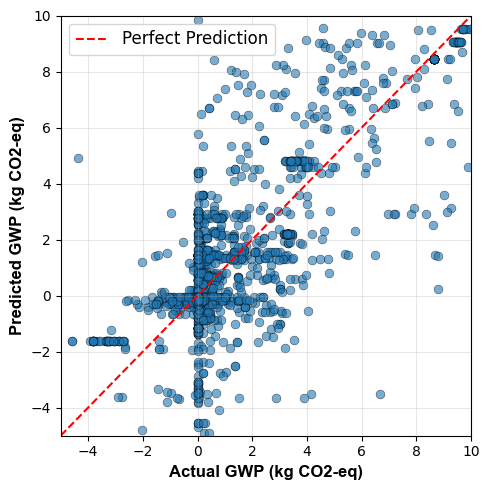

In [ ]:
# 
# F
y_test_filtered_neg5_10 = y_test.values
xgb_preds_filtered_neg5_10 = xgb_preds
# Create a mask for values within the range
mask_neg5_10 = (y_test_filtered_neg5_10 >= -5) & (y_test_filtered_neg5_10 <= 10) & (xgb_preds_filtered_neg5_10 >= -5) & (xgb_preds_filtered_neg5_10 <= 10)
y_test_zoom_neg5_10 = y_test_filtered_neg5_10[mask_neg5_10]
xgb_preds_zoom_neg5_10 = xgb_preds_filtered_neg5_10[mask_neg5_10]  
print(f"Original data points: {len(y_test_filtered_neg5_10)}")
print(f"Filtered data points: {len(y_test_zoom_neg5_10)}")  
# Create scatterplot with zoomed range -5 to 10
fig, ax = plt.subplots(figsize=(5, 5))
# Rasterize scatter points to keep SVG file size manageable
ax.scatter(y_test_zoom_neg5_10, xgb_preds_zoom_neg5_10, alpha=0.6, s=40, edgecolors='black', linewidth=0.4, rasterized=True)
ax.set_xlabel("Actual GWP (kg CO2-eq)", fontsize=12, fontweight='bold', fontname='Arial')
ax.set_ylabel("Predicted GWP (kg CO2-eq)", fontsize=12, fontweight='bold', fontname='Arial')
# ax.set_title("Scenario A: Actual vs Predicted", fontsize=12, fontweight='bold', fontname='Arial')
ax.plot([-5, 10], [-5, 10], 'r--', linewidth=1.5, label='Perfect Prediction')
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)
fig.tight_layout()
# Save as SVG (vector) with rasterized scatter points, then as 300 DPI PNG
svg_file_neg5_10 = 'xgboost_scatter_test_zoomed_neg5_10.svg'
fig.savefig(svg_file_neg5_10, format='svg', bbox_inches='tight')
png_file_neg5_10 = 'xgboost_scatter_test_zoomed_neg5_10.png'
fig.savefig(png_file_neg5_10, format='png', dpi=300, bbox_inches='tight')
print(f"Saved: {svg_file_neg5_10} and {png_file_neg5_10}")
plt.show()


Original data points: 2811
Filtered data points: 883
Saved: ann_scatter_test_zoomed_neg5_10.svg and ann_scatter_test_zoomed_neg5_10.png


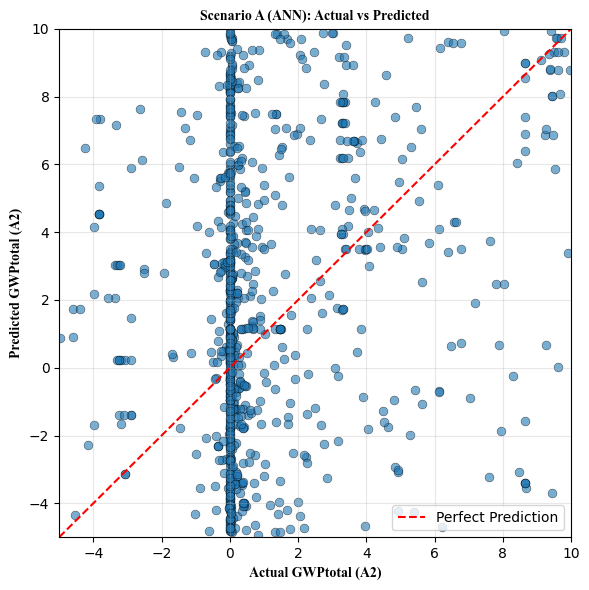

In [11]:
# exact similar plot from range -5 ti 10 for ANN
# Filter data to range -5 to 10 for both actual and predicted (ANN)
y_test_filtered_ann_neg5_10 = y_test.values
ann_preds_filtered_neg5_10 = ann_preds
# Create a mask for values within the range
mask_ann_neg5_10 = (y_test_filtered_ann_neg5_10 >= -5) & (y_test_filtered_ann_neg5_10 <= 10) & (ann_preds_filtered_neg5_10 >= -5) & (ann_preds_filtered_neg5_10 <= 10)
y_test_zoom_ann_neg5_10 = y_test_filtered_ann_neg5_10[mask_ann_neg5_10]
ann_preds_zoom_neg5_10 = ann_preds_filtered_neg5_10[mask_ann_neg5_10]  
print(f"Original data points: {len(y_test_filtered_ann_neg5_10)}")  
print(f"Filtered data points: {len(y_test_zoom_ann_neg5_10)}")  
# Create scatterplot with zoomed range -5 to 10 for ANN
fig, ax = plt.subplots(figsize=(6, 6))
# Rasterize scatter points to keep SVG file size manageable
ax.scatter(y_test_zoom_ann_neg5_10, ann_preds_zoom_neg5_10, alpha=0.6, s=40, edgecolors='black', linewidth=0.4, rasterized=True)
ax.set_xlabel("Actual GWPtotal (A2)", fontsize=10, fontweight='bold', fontname='Times New Roman')
ax.set_ylabel("Predicted GWPtotal (A2)", fontsize=10, fontweight='bold', fontname='Times New Roman')
ax.set_title("Scenario A (ANN): Actual vs Predicted", fontsize=10, fontweight='bold', fontname='Times New Roman')
ax.plot([-5, 10], [-5, 10], 'r--', linewidth=1.5, label='Perfect Prediction')
ax.set_xlim(-5, 10) 
ax.set_ylim(-5, 10)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
fig.tight_layout()
# Save as SVG (vector) with rasterized scatter points, then as 300 DPI PNG
svg_file_ann_neg5_10 = 'ann_scatter_test_zoomed_neg5_10.svg'
fig.savefig(svg_file_ann_neg5_10, format='svg', bbox_inches='tight')
png_file_ann_neg5_10 = 'ann_scatter_test_zoomed_neg5_10.png'
fig.savefig(png_file_ann_neg5_10, format='png', dpi=300, bbox_inches='tight')
print(f"Saved: {svg_file_ann_neg5_10} and {png_file_ann_neg5_10}")
plt.show()  

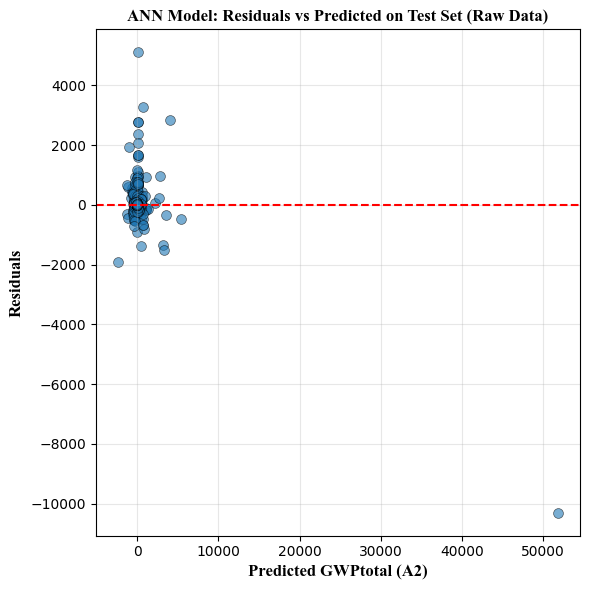

In [12]:
# residucal error plot for ANN
residuals_ann = y_test.values - ann_preds
plt.figure(figsize=(6, 6))
plt.scatter(ann_preds, residuals_ann, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.axhline(0, color='r', linestyle='--', linewidth=1.5)
plt.xlabel("Predicted GWPtotal (A2)", fontsize=12, fontweight='bold', fontname='Times New Roman')
plt.ylabel("Residuals", fontsize=12, fontweight='bold', fontname='Times New Roman')
plt.title("ANN Model: Residuals vs Predicted on Test Set (Raw Data)",   fontsize=12, fontweight='bold', fontname='Times New Roman') 
plt.grid(True, alpha=0.3)
plt.tight_layout()  
plt.savefig('ann_residuals_plot.png', dpi=300, bbox_inches='tight')
import pandas as pd
residuals_df_ann = pd.DataFrame({'Predicted': ann_preds, 'Residuals': residuals_ann})
residuals_df_ann.to_csv("ann_residuals.csv", index=False)               